In [2]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import ggplot
import seaborn as sns
import random
import xgboost as xgb
import datetime as dt
from scipy.stats import gaussian_kde
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
%matplotlib inline

#Global variables
test_size = 0.25

/Library/Python/2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Python/2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Python/2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets

# Table of Contents

1. Exploring the Data
2. Building a DataFrame and Standard Algorithm
3. Feature engineering/Feature Selection
4. Tuning the algorithm
5. Conclusions

## Exploring the Data


### Univariant Analysis

So lets take a first glance at what we have here:
    
- 6 files, all related by the key 'id'. Seems like we have to break down these relations first in order to get a coherent dataframe

After quickly scrolling through the data in MS Excel, i decided to do the following:
In order to just process numeric data, i dropped the strings from all the csv files containing the description ('event_type ', 'log_feature ', 'resource_type') manually with the replace function.



| id,event_type  	|   	
|:-:	|
|62093, ~~event_type~~ 15   	|





In [2]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

severity_type = pd.read_csv("Telstra/severity_type.csv")
severity_type_order = severity_type[['id']].drop_duplicates()
severity_type_order['order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)

print severity_type_order.shape

(18552, 2)


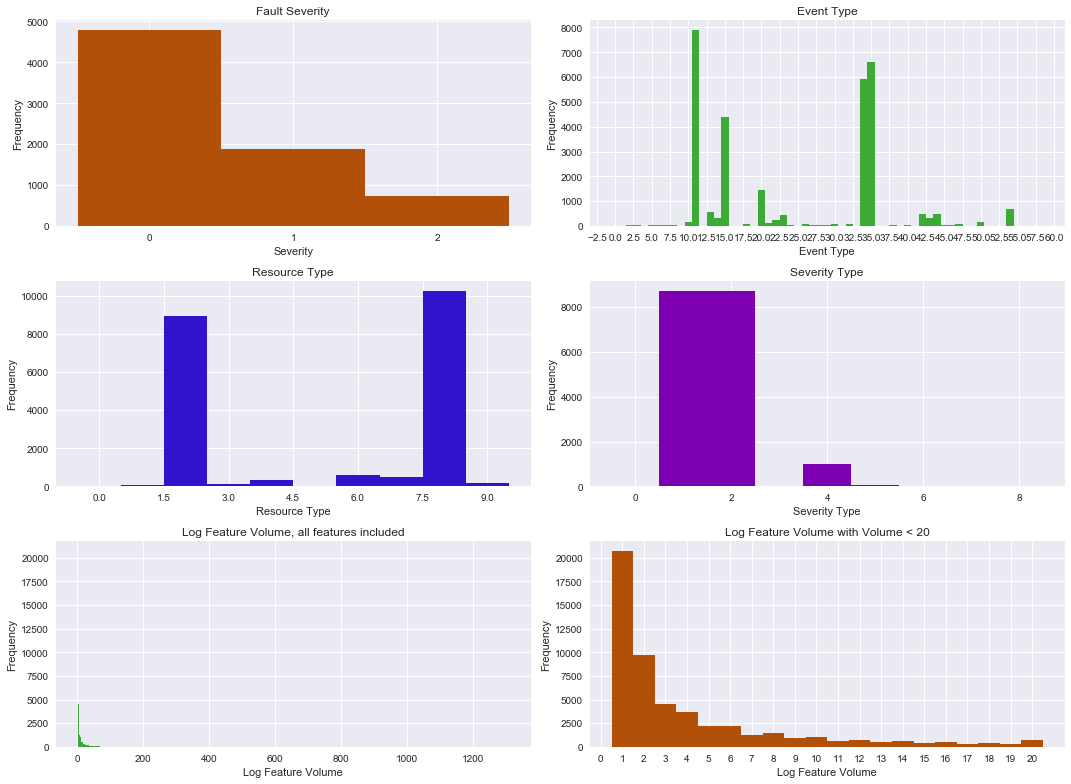

In [3]:
fig = plt.figure(figsize=(15,11))

###Fault Severity
ax1 = fig.add_subplot(321)
ax1.set_title('Fault Severity')
ax1.hist(train.fault_severity, bins=np.arange(4) - 0.5, color='#B25009')
ax1.set_xlabel('Severity')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(3))

### Event Type
ax2 = fig.add_subplot(322)
ax2.set_title('Event Type')
ax2.hist(events.event_type, bins=np.arange(60)-0.5,color='#3baa36')
ax2.set_xlabel('Event Type')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(60))
ax2.xaxis.set_major_locator(plt.MaxNLocator(30))


##Resource Type
ax3 = fig.add_subplot(323)
ax3.set_title('Resource Type')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Resource Type')
ax3.hist(resources.resource_type, bins=np.arange(11)-0.5, color = '#3014CC')
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))

#Severity Type
ax4 = fig.add_subplot(324)
ax4.set_title('Severity Type')
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Severity Type')
ax4.hist(severity.severity_type, bins=np.arange(10)-0.5, color = '#7C00B2')

#Log Feature (All Datapoints)
ax5 = fig.add_subplot(325)
ax5.set_title('Log Feature Volume, all features included')
ax5.set_xlabel('Log Feature Volume')
ax5.set_ylabel('Frequency')
ax5.hist(log_feature.volume,bins=np.arange(log_feature.volume.min(), log_feature.volume.max()+1), align='left',color='#3baa36')

#Log Feature (All Datapoints)
ax6 = fig.add_subplot(326)
ax6.set_title('Log Feature Volume with Volume < 20')
ax6.set_xlabel('Log Feature Volume')
ax6.set_ylabel('Frequency')
ax6.set_xticks(range(21))
ax6.hist(log_feature.volume, bins=np.arange(log_feature.volume.min(), 22), align='left',color='#B25009')

#Display the figure
plt.tight_layout()
sns.plt.show()
fig.savefig('fig.png')

Our trainset shows the reports of 7381 incidents in total. Here is what i found out after graphing some of the data.


- As we can see, most of the interruptions are just a temporary network glitch ( *Fault Severity* = 0), but 1 and 2 do seem to cause problems quite frequently (around 35% of the time).

- The *event types* 11,35 and 34, 15 and 2 seem occur a lot together with a network incident ...


- The *resource types* 8 and 2 are used most. There is a significant gap between these two resources and the rest.

- The *severity type of warning messages* 1 and 2 seem to be the most frequent ones.

- The *log features* behave a little different here: We have a bunch of different features, which occur in a different Frequency (Volume). The two graphs above show just how often a given feature appears with an issue.
 Since the feature with the largest volume occurs 1350 times, the graph on the bottom left corner is highly skewed.


### Building a DataFrame and Standard Algorithm

Since the features are distributed over severall files and exist in a one-to-many fashion (one id can exist in N rows), its difficult to process them. In order to do so, the data has to be merged together in one single dataframe. 

In [4]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")


####### Saving labels
y = train.copy()
y = y.drop('location', axis=1)
y = y.drop('id', axis = 1)
train = train.drop('fault_severity', axis = 1)


##Feature engineering
###trainset with id & location
train['loc_count'] = train.groupby(['location'])['location'].transform('count')

##Feature engineering
### Add Severity type and severity type order
severity_type_order = severity[['id']].drop_duplicates()
severity_type_order['severity_order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)
train = pd.merge(train, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
train = pd.merge(train, severity_type_order, how='inner', on='id')





#pd.set_option('display.max_rows',5000)
#pd.reset_option('display.max_rows')

### Add Resources
resources = pd.get_dummies(resources, columns=['resource_type'])
resources = resources.groupby(['id']).sum()
resources = resources.reset_index()
train = pd.merge(train, resources, on='id',how='left')


### Add Event Type
events = pd.get_dummies(events, columns=['event_type'])
events = events.groupby(['id']).sum()
events = events.reset_index()
train = pd.merge(train, events, on='id',how='left')


## volume-hot encoding & Appending the log_features to the trainset, order is preserved
log_feature = pd.get_dummies(log_feature, columns=['log_feature'])
volume =  log_feature['volume'].as_matrix()
volume = np.transpose(np.atleast_2d(volume))
only_features = log_feature.iloc[:,2:].as_matrix()
only_features = volume*only_features
log_feature_vhot = pd.DataFrame(only_features, index=log_feature.index)
log_feature_vhot.columns = log_feature.iloc[:,2:].columns
log_feature_vhot['id'] = pd.Series(log_feature['id'])

# move the column to head of list using index, pop and insert
cols = list(log_feature_vhot)
cols.insert(0, cols.pop(cols.index('id')))
log_feature_vhot = log_feature_vhot.loc[:, cols]


#merge vhot into log_feature
log_feature = log_feature_vhot.groupby(['id']).sum()
log_feature = log_feature.reset_index()
#pd.options.display.max_columns = 15
#print log_feature.head(5)

train = pd.merge(train, log_feature, on='id',how='left')



In [5]:
print train

         id  location  loc_count  severity_type  severity_order  \
0     14121       118         33              2        0.170009   
1      9320        91         49              2        0.912947   
2     14394       152          5              2        0.231458   
3      8218       931         33              1        0.932514   
4     14804       120         12              1        0.177285   
5      1080       664          8              1        0.619502   
6      9731       640          5              4        0.590934   
7     15505       122         56              2        0.179064   
8      3443       263          2              2        0.306328   
9     13300       613         39              1        0.575356   
10     8976       760         26              1        0.715233   
11     7965       519          9              2        0.528946   
12    10342       746          2              1        0.707848   
13     6741      1066          9              1        0.10160

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model_fe = xgb.XGBClassifier(eval_metric='mlogloss',max_depth=5)
model_fe.fit(X_train, y_train.values.ravel())
print(model_fe)
y_pred = model_fe.predict_proba(X_test)
print("Logloss: %.3f" % log_loss(y_test['fault_severity'].as_matrix(columns=None),y_pred))
#train.to_csv(path_or_buf='Telstra/understand_train.csv',index=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Logloss: 0.560


We now have a 7381x453 train dataset, since 'resources', 'events' and 'log_features' are all one-hot-encoded.
While searching for a matching algorithm that can fit such sparse data precisely, i found out about xgboost, which is a gradient boosting algorithm based on decision trees.

Now that we have created our dataframe with all our features, lets run the xgboost algorithm with its initial configuration for the first time on it to check whats happening.


In [7]:
#### general settings l


X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
#define classifier, to tune only once
def xgboost_classif():
    return xgb.XGBClassifier(eval_metric='mlogloss', max_depth=5)
def random_xgboost_classif():
    childweight = random.choice(range(1,3))
    eta = 0.01*float(random.choice(range(1,4)))
    bytree = 0.01*float(random.choice(range(1,25)))
    md = random.choice(range(3,8))
    SS = 0.01*float(random.choice(range(1,9)))
    LAMBDA = random.choice([0, 0.1, 0.5])
    est = 1000
    parameters = {'min_child_weight': childweight,
                  'n_estimators' : est,
                  'learning_rate': eta,
                  'colsample_bytree': bytree,
                  'max_depth': md,
                  'subsample': SS,
                  'lambda': LAMBDA,
                  'objective': 'multi:softprob',
                  'silent': 1,
                  }
    return parameters


model_1 = xgboost_classif()
model_1.fit(X_train, y_train.values.ravel())
print(model_1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [29]:
## Show score
y_pred = model_1.predict_proba(X_test)
print("Logloss: %.3f" % log_loss(y_test['fault_severity'].as_matrix(columns=None),y_pred))
#print("Logloss: %.3f" % log_loss(y_test,y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [1846, 1847]

In [9]:
### Add Severity type,Resources, Event Type, log_features to test
test = pd.read_csv("Telstra/test.csv")
test['loc_count'] = test.groupby(['location'])['location'].transform('count')
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')
print test

          id  location  loc_count  severity_type  severity_order  \
0      11066       481         19              2        0.475151   
1      18000       962         86              1        0.961945   
2      16964       491         18              2        0.488734   
3       4795       532         14              5        0.535414   
4       3392       600         72              2        0.561611   
5       3795       794         52              1        0.745041   
6       2881       375         15              2        0.368963   
7       1903       638         43              1        0.588885   
8       5245       690         15              1        0.636104   
9       6726       893         29              4        0.884271   
10      1311       418         10              4        0.393650   
11     15795       320          3              2        0.341257   
12      4315      1013          6              2        0.022639   
13      3393       931         36              1

In [10]:
##Creating the final prediction data and submit it to kaggle.

test_pred = model_fe.predict_proba(test)
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
print final_pred
prij
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)

We scored a logloss of .559% if we include ALL features (no feature engineering) and not further tune the parameters of our xgboost algorithm.

Our Kaggle score is 0.58768 with this very standard model, which would bring us to the 580th place on the leaderboard, if the competition was still on. Lets see if we can further improve this simple model.

## Feature engineering/Feature Selection
Luckily, xgboost provides a way to have a look on which features are the most predictive ones. In order to do so, we test our prediction with different threshholds, and see which one will get us the highest accuracy.

In [31]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model_2 = xgboost_classif()
model_2.fit(X_train, y_train.values.ravel())

# Fit model using each importance as a threshold
thresholds = -np.sort(-model_2.feature_importances_,)
thresholds = np.unique(thresholds)


In [32]:
i = 0
for thresh in thresholds:
    if i<50:
        i+=1
        # select features using threshold
        selection = SelectFromModel(model_2, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = xgboost_classif()
        selection_model.fit(select_X_train, y_train.values.ravel())
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict_proba(select_X_test)
        #print y_pred
        #print y_test['fault_severity'].as_matrix(columns=None)
        loss = log_loss(y_test['fault_severity'].as_matrix(columns=None),y_pred)
        print("Thresh=%.5f, n=%d, Log_loss: %.4f" % (thresh, select_X_train.shape[1], loss))

Thresh=0.00000, n=454, Log_loss: 0.5600
Thresh=0.00021, n=130, Log_loss: 0.5600
Thresh=0.00043, n=122, Log_loss: 0.5604
Thresh=0.00064, n=114, Log_loss: 0.5595
Thresh=0.00085, n=106, Log_loss: 0.5588
Thresh=0.00107, n=97, Log_loss: 0.5600
Thresh=0.00128, n=94, Log_loss: 0.5609
Thresh=0.00149, n=87, Log_loss: 0.5589
Thresh=0.00171, n=81, Log_loss: 0.5613
Thresh=0.00192, n=74, Log_loss: 0.5618
Thresh=0.00213, n=71, Log_loss: 0.5596
Thresh=0.00235, n=65, Log_loss: 0.5626
Thresh=0.00277, n=62, Log_loss: 0.5655
Thresh=0.00299, n=60, Log_loss: 0.5674
Thresh=0.00320, n=58, Log_loss: 0.5668
Thresh=0.00341, n=56, Log_loss: 0.5660
Thresh=0.00363, n=55, Log_loss: 0.5653
Thresh=0.00384, n=53, Log_loss: 0.5669
Thresh=0.00405, n=52, Log_loss: 0.5663
Thresh=0.00427, n=49, Log_loss: 0.5681
Thresh=0.00448, n=48, Log_loss: 0.5706
Thresh=0.00469, n=46, Log_loss: 0.5709
Thresh=0.00491, n=45, Log_loss: 0.5693
Thresh=0.00512, n=42, Log_loss: 0.5715
Thresh=0.00534, n=41, Log_loss: 0.5715
Thresh=0.00555, n=40

When we run the outcommented code above, it shows no improvement if we drop some of the features. So apparently this is a dead end road. Lets see if there are other things we could do.


In [13]:
#########################################
######### Marked for Deletion############
#########################################

##prepare the testset again
test = pd.read_csv("Telstra/test.csv")
test['loc_count'] = test.groupby(['location'])['location'].transform('count')
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')


###rerun initial model, use up all the data for training
model_3 = xgboost_classif()
model_3.fit(train, y.values.ravel())

## select features using threshold
selection = SelectFromModel(model_3, threshold=0.000215, prefit=True)
select_X_train = selection.transform(train)
## train model
selection_model = xgboost_classif()
selection_model.fit(select_X_train, y.values.ravel())
select_X_test_final = selection.transform(test)
y_pred_final = selection_model.predict_proba(select_X_test_final)
#create final dataframe
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = y_pred_final)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)


#########################################
######### Marked for Deletion############
#########################################

Nice! I submitted the final_pred to kaggle, we improved our logloss down to .54026 on the public board. Time for some more research on this.
Since the data is now much more compact, i will have another look at it in MS Excel and see whethere i can up with any new ideas.

In [14]:
#########################################
######### Marked for Deletion############
#########################################
#Converting the new trainset (select_X_train) back to a pandas frame
select_X_train=pd.DataFrame(select_X_train)
labels = train.iloc[:, selection.get_support()]
select_train = pd.DataFrame(selection.transform(train), columns=labels.columns)
#select_train.to_csv(path_or_buf='Telstra/understand_select.csv',index=False)


In [15]:
#########################################
######### Marked for Deletion############
#########################################
##decided to test some random features
#parameters = random_xgboost_classif()
#dtrain = xgboost.DMatrix(train[list(train.columns)].values, label=train['fault_severity'].values, missing=-9999)

#dtrain = xgb.DMatrix( train, label=y)
#result = xgb.cv(parameters, dtrain, 350, nfold=10, metrics={'mlogloss'}, seed=0,verbose_eval= True, early_stopping_rounds= 5)
#print result
#result_df = parse_xgb_cv_result(result)
#print result_df


Since feature selection by using the feature importance scores of the built in xgboost 

In [16]:

from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

#train = pd.read_csv('train_modified.csv')
train['fault_severity'] = y
target = 'fault_severity'
IDcol = 'id'

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=30):
    # thanks to https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    if useTrainCV: 
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain,num_boost_round=alg.get_params()['n_estimators'], verbose_eval = True, nfold=10, feval=evalerror, seed=0, early_stopping_rounds= early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        dtrain_fs = np.transpose(np.atleast_2d(dtrain['fault_severity'].values))
      
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['fault_severity'],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])
    dtrain_pred = np.transpose(np.atleast_2d(dtrain_predictions))
    #Print model report:
    print "\nModel Report"
    print "Logloss : %.4g" % log_loss(dtrain_fs,dtrain_predprob)

def evalerror(xtrain, labels):
    return 'mlogloss', log_loss(labels.get_label(),xtrain)
                    

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
#n_estimators=1000,
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,  
 max_depth=5,
 num_class = 3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='multi:softprob',
 scale_pos_weight=1,
 )

modelfit(xgb1, train, predictors)

[0]	train-merror:0.265447+0.00540133	train-mlogloss:1.03695+0.000478812	test-merror:0.280352+0.0159459	test-mlogloss:1.0388+0.00160095
[1]	train-merror:0.25259+0.00806556	train-mlogloss:0.981072+0.00197646	test-merror:0.266667+0.0139481	test-mlogloss:0.985135+0.0026719
[2]	train-merror:0.248615+0.00527588	train-mlogloss:0.933603+0.00287413	test-merror:0.261924+0.00952475	test-mlogloss:0.939412+0.00437947
[3]	train-merror:0.247109+0.00352234	train-mlogloss:0.892016+0.00360867	test-merror:0.262195+0.0117857	test-mlogloss:0.899797+0.00617001
[4]	train-merror:0.246176+0.0029745	train-mlogloss:0.85507+0.00384534	test-merror:0.260434+0.0103516	test-mlogloss:0.864636+0.00716366
[5]	train-merror:0.244911+0.00273669	train-mlogloss:0.822771+0.00342517	test-merror:0.257859+0.00865647	test-mlogloss:0.833929+0.00756491
[6]	train-merror:0.244264+0.00244361	train-mlogloss:0.793678+0.00279657	test-merror:0.255014+0.00980525	test-mlogloss:0.806158+0.00792001
[7]	train-merror:0.244008+0.00250861	train-m

[61]	train-merror:0.202123+0.00374295	train-mlogloss:0.471624+0.00213919	test-merror:0.240786+0.0107219	test-mlogloss:0.536475+0.0135705
[62]	train-merror:0.200948+0.0038837	train-mlogloss:0.470178+0.00217189	test-merror:0.241192+0.0117036	test-mlogloss:0.535766+0.0135576
[63]	train-merror:0.200346+0.00421121	train-mlogloss:0.468876+0.00233484	test-merror:0.240379+0.0109783	test-mlogloss:0.53514+0.0134711
[64]	train-merror:0.199037+0.00395822	train-mlogloss:0.467446+0.00239727	test-merror:0.241463+0.0113176	test-mlogloss:0.534301+0.0134821
[65]	train-merror:0.198028+0.00384265	train-mlogloss:0.466086+0.0025267	test-merror:0.240921+0.0125924	test-mlogloss:0.533565+0.0135549
[66]	train-merror:0.196447+0.00406709	train-mlogloss:0.464758+0.00251405	test-merror:0.240244+0.0126832	test-mlogloss:0.532835+0.0133974
[67]	train-merror:0.19592+0.00416538	train-mlogloss:0.463602+0.00270956	test-merror:0.239837+0.0124781	test-mlogloss:0.532169+0.0133257
[68]	train-merror:0.195227+0.00441633	train-m

[122]	train-merror:0.162255+0.0027573	train-mlogloss:0.408728+0.00256463	test-merror:0.229133+0.0143587	test-mlogloss:0.512919+0.0144673
[123]	train-merror:0.161758+0.00259649	train-mlogloss:0.408064+0.00246724	test-merror:0.228591+0.0146198	test-mlogloss:0.512852+0.0144919
[124]	train-merror:0.161006+0.00303899	train-mlogloss:0.407183+0.00246928	test-merror:0.227507+0.0136776	test-mlogloss:0.512573+0.0145408
[125]	train-merror:0.160825+0.00292006	train-mlogloss:0.40637+0.00251327	test-merror:0.227507+0.0148984	test-mlogloss:0.512285+0.0146771
[126]	train-merror:0.160042+0.00264657	train-mlogloss:0.405392+0.00263707	test-merror:0.227371+0.0145789	test-mlogloss:0.512004+0.0147555
[127]	train-merror:0.159425+0.00259688	train-mlogloss:0.404615+0.00264786	test-merror:0.2271+0.0151519	test-mlogloss:0.511839+0.0147033
[128]	train-merror:0.158958+0.00257169	train-mlogloss:0.403712+0.00261812	test-merror:0.227236+0.0153308	test-mlogloss:0.511567+0.0147088
[129]	train-merror:0.15828+0.00270432	

[182]	train-merror:0.135336+0.00252063	train-mlogloss:0.364373+0.00300628	test-merror:0.223848+0.0145913	test-mlogloss:0.503937+0.0147608
[183]	train-merror:0.134794+0.0025676	train-mlogloss:0.363793+0.00301194	test-merror:0.223712+0.0142172	test-mlogloss:0.503826+0.0147012
[184]	train-merror:0.134432+0.0024671	train-mlogloss:0.363118+0.00299488	test-merror:0.223306+0.0136956	test-mlogloss:0.503649+0.0146964
[185]	train-merror:0.133906+0.00242784	train-mlogloss:0.362416+0.00299324	test-merror:0.22317+0.01351	test-mlogloss:0.503445+0.0147307
[186]	train-merror:0.133484+0.00239484	train-mlogloss:0.361832+0.00290022	test-merror:0.223577+0.0138449	test-mlogloss:0.503335+0.0147411
[187]	train-merror:0.133198+0.00241194	train-mlogloss:0.361313+0.00286048	test-merror:0.223306+0.0143246	test-mlogloss:0.503372+0.0147071
[188]	train-merror:0.132731+0.00229559	train-mlogloss:0.360724+0.00277532	test-merror:0.223442+0.0149842	test-mlogloss:0.503426+0.0147618
[189]	train-merror:0.132249+0.0024062	t

[242]	train-merror:0.114649+0.00185665	train-mlogloss:0.329036+0.00229908	test-merror:0.219783+0.0130784	test-mlogloss:0.498903+0.0155299
[243]	train-merror:0.114228+0.00186355	train-mlogloss:0.328501+0.00239129	test-merror:0.219647+0.0133926	test-mlogloss:0.498969+0.0154977
[244]	train-merror:0.114077+0.00183528	train-mlogloss:0.327931+0.00242591	test-merror:0.219783+0.0130221	test-mlogloss:0.498739+0.0154806
[245]	train-merror:0.11346+0.00188667	train-mlogloss:0.327399+0.00238291	test-merror:0.219783+0.0128946	test-mlogloss:0.498588+0.015637
[246]	train-merror:0.113129+0.00186737	train-mlogloss:0.326847+0.0023079	test-merror:0.219783+0.0133149	test-mlogloss:0.498393+0.0157083
[247]	train-merror:0.112903+0.00183337	train-mlogloss:0.326369+0.00230467	test-merror:0.220461+0.0129408	test-mlogloss:0.498441+0.0156643
[248]	train-merror:0.112722+0.00185014	train-mlogloss:0.325795+0.00224345	test-merror:0.220461+0.0125372	test-mlogloss:0.498316+0.0154793
[249]	train-merror:0.112195+0.0018299

[302]	train-merror:0.0970792+0.00160287	train-mlogloss:0.299103+0.00191224	test-merror:0.218834+0.0153211	test-mlogloss:0.496394+0.0160131
[303]	train-merror:0.096763+0.00147051	train-mlogloss:0.298664+0.00195816	test-merror:0.217615+0.0152002	test-mlogloss:0.49645+0.0160615
[304]	train-merror:0.0963414+0.00151819	train-mlogloss:0.298217+0.00197496	test-merror:0.217615+0.0151639	test-mlogloss:0.496514+0.0158977
[305]	train-merror:0.0960556+0.00155295	train-mlogloss:0.297747+0.00194712	test-merror:0.217344+0.0155583	test-mlogloss:0.496494+0.0158758
[306]	train-merror:0.0957544+0.00147205	train-mlogloss:0.297317+0.0019691	test-merror:0.217886+0.0160646	test-mlogloss:0.4965+0.0158453
[307]	train-merror:0.0952876+0.00152128	train-mlogloss:0.296883+0.00193474	test-merror:0.217751+0.0146697	test-mlogloss:0.496531+0.0157957
[308]	train-merror:0.0951069+0.00150273	train-mlogloss:0.296386+0.00191812	test-merror:0.216938+0.0158419	test-mlogloss:0.496542+0.0158271
[309]	train-merror:0.0949564+0.0

So after i ran the cross validation with more estimators (had to use a EC2-instance to do so) i found out that i could improve the results down to 0.50 by increasing the number of estimators up to 488. After that i started tuning the rest of the parameters.

In [18]:
test = pd.read_csv("Telstra/test.csv")
test['loc_count'] = test.groupby(['location'])['location'].transform('count')
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')
test_pred = xgb1.predict_proba(test)
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']

In [20]:
param_test1 = {
 'max_depth':range(5,6,1),
 'min_child_weight':range(1,3,1)
}
#tried gridseach with depth from 3 to 7
#and min_child_weight from 1 to 5 
#result {'max_depth': 5, 'min_child_weight': 1}
time0 = dt.datetime.now()
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=488, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'multi:softprob', scale_pos_weight=1), 
param_grid = param_test1,n_jobs=4,iid=False, cv=5,scoring ='neg_log_loss')

gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_
print gsearch1.best_params_
print gsearch1.best_score_
time1 = dt.datetime.now()
print 'total:', (time1-time0).seconds, 'seconds'

{'max_depth': 5, 'min_child_weight': 1}
-0.515769576646
total: 715 seconds


In [21]:
param_test2 = {
    'gamma':[i/10.0 for i in range(5,13)]
}
time2 = dt.datetime.now()
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=488, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'multi:softprob', scale_pos_weight=1),
param_grid = param_test2,n_jobs=4,iid=False, cv=5,scoring ='neg_log_loss')
time3 = dt.datetime.now()
gsearch2.fit(train[predictors],train[target])
print 'total:', (time3-time2).seconds, 'seconds'
print gsearch2.cv_results_
print gsearch2.best_params_
print gsearch2.best_score_


total: 0 seconds
{'rank_test_score': array([8, 7, 6, 2, 5, 4, 3, 1], dtype=int32), 'split4_test_score': array([-0.51310023, -0.5142582 , -0.51246859, -0.50683908, -0.50998576,
       -0.50625418, -0.50521174, -0.50744048]), 'mean_score_time': array([ 0.20650854,  0.23024883,  0.23743153,  0.17641683,  0.21628976,
        0.33505926,  0.30068579,  0.17434602]), 'std_test_score': array([ 0.01865208,  0.01937724,  0.01779793,  0.01811524,  0.0157315 ,
        0.0171276 ,  0.01721421,  0.01572645]), 'std_train_score': array([ 0.00432315,  0.00327552,  0.00252944,  0.00311493,  0.00302294,
        0.00394245,  0.00270748,  0.00440025]), 'param_gamma': masked_array(data = [0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2],
             mask = [False False False False False False False False],
       fill_value = ?)
, 'split1_train_score': array([-0.23651502, -0.2436576 , -0.25267529, -0.26327618, -0.2733075 ,
       -0.28514097, -0.29426208, -0.30694621]), 'split0_test_score': array([-0.54151503, -0.54007439

In [22]:
# {'gamma': 0.8}
param_test3 = {
 'subsample':[i/10.0 for i in range(8,10)],
 'colsample_bytree':[i/10.0 for i in range(6,9)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=488, max_depth=5,
min_child_weight=1, gamma=0.8, subsample=0.8, colsample_bytree=0.8,
objective= 'multi:softprob', scale_pos_weight=1),
param_grid = param_test3,n_jobs=4,iid=False, cv=5,scoring ='neg_log_loss')
gsearch3.fit(train[predictors],train[target])
print gsearch3.best_params_
print gsearch3.best_score_

{'subsample': 0.9, 'colsample_bytree': 0.7}
-0.504042167206


In [26]:
print gsearch1.best_params_
print gsearch2.best_params_
print gsearch3.best_params_

{'max_depth': 5, 'min_child_weight': 1}
{'gamma': 1.2}
{'subsample': 0.9, 'colsample_bytree': 0.7}


In [ ]:
#{'colsample_bytree': 0.7, 'subsample': 0.9}
param_test4 = {
 'reg_alpha':[1e-5, 2e-5, 4e-5, 5e-5, 6e-5, 8e-5]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=488, max_depth=5,
min_child_weight=1, gamma=0.8, subsample=0.9, colsample_bytree=0.6,
objective= 'multi:softprob', scale_pos_weight=1),
param_grid = param_test4,n_jobs=4,iid=False, cv=5,scoring ='neg_log_loss')
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_

In [29]:
#{'reg_alpha': 6e-05}
predictors = [x for x in train.columns if x not in [target]]
xgb_final= XGBClassifier( n_estimators=488, max_depth=5,
min_child_weight=1, subsample=0.9, colsample_bytree=0.7,
objective= 'multi:softprob', scale_pos_weight=1,reg_alpha = 6e-05 )
modelfit(xgb_final, train, predictors)


[0]	train-merror:0.266275+0.0050898	train-mlogloss:1.03746+0.000459863	test-merror:0.282249+0.0155093	test-mlogloss:1.03947+0.00181001
[1]	train-merror:0.255315+0.0100216	train-mlogloss:0.983655+0.003277	test-merror:0.269377+0.0142991	test-mlogloss:0.987766+0.00460147
[2]	train-merror:0.250964+0.00866123	train-mlogloss:0.936359+0.00354661	test-merror:0.262331+0.0128149	test-mlogloss:0.942021+0.00456666
[3]	train-merror:0.248178+0.00322438	train-mlogloss:0.895089+0.00305386	test-merror:0.261518+0.0116565	test-mlogloss:0.902532+0.00565527
[4]	train-merror:0.246146+0.00365462	train-mlogloss:0.857723+0.00332747	test-merror:0.260298+0.0107459	test-mlogloss:0.867062+0.00681104
[5]	train-merror:0.24467+0.00221818	train-mlogloss:0.825738+0.0030321	test-merror:0.259079+0.0123569	test-mlogloss:0.836579+0.00740374
[6]	train-merror:0.244083+0.00273823	train-mlogloss:0.79715+0.00235242	test-merror:0.257317+0.0124259	test-mlogloss:0.809502+0.00794953
[7]	train-merror:0.243526+0.00217179	train-mloglo

[61]	train-merror:0.204291+0.00302565	train-mlogloss:0.473822+0.00294319	test-merror:0.243767+0.0136644	test-mlogloss:0.539364+0.013099
[62]	train-merror:0.203508+0.00332532	train-mlogloss:0.4726+0.00294503	test-merror:0.244038+0.0137582	test-mlogloss:0.538736+0.0130906
[63]	train-merror:0.202695+0.00357677	train-mlogloss:0.471346+0.00286311	test-merror:0.244444+0.0132101	test-mlogloss:0.537906+0.0131329
[64]	train-merror:0.202018+0.00366538	train-mlogloss:0.470186+0.00283545	test-merror:0.243902+0.0134961	test-mlogloss:0.537216+0.0131882
[65]	train-merror:0.201235+0.00362234	train-mlogloss:0.469053+0.00292082	test-merror:0.242818+0.0129801	test-mlogloss:0.536578+0.0132324
[66]	train-merror:0.200271+0.00341257	train-mlogloss:0.467718+0.0027925	test-merror:0.242683+0.0125141	test-mlogloss:0.535914+0.0133607
[67]	train-merror:0.198991+0.00361026	train-mlogloss:0.466528+0.00281747	test-merror:0.242141+0.0124494	test-mlogloss:0.535257+0.0132254
[68]	train-merror:0.198043+0.00343126	train-m

[122]	train-merror:0.165417+0.00354872	train-mlogloss:0.414026+0.00285626	test-merror:0.232927+0.0150455	test-mlogloss:0.514488+0.0152462
[123]	train-merror:0.165086+0.00335918	train-mlogloss:0.413319+0.00284413	test-merror:0.232385+0.0150553	test-mlogloss:0.51426+0.0152496
[124]	train-merror:0.164785+0.0032539	train-mlogloss:0.412495+0.00291918	test-merror:0.232791+0.0152919	test-mlogloss:0.51413+0.0153123
[125]	train-merror:0.164213+0.00312438	train-mlogloss:0.411714+0.00300006	test-merror:0.233604+0.0159778	test-mlogloss:0.513769+0.0152075
[126]	train-merror:0.163731+0.00360592	train-mlogloss:0.410871+0.00295563	test-merror:0.232927+0.0159691	test-mlogloss:0.513492+0.0153161
[127]	train-merror:0.163129+0.00336003	train-mlogloss:0.410198+0.00294051	test-merror:0.233333+0.0158808	test-mlogloss:0.513359+0.01523
[128]	train-merror:0.162722+0.0032942	train-mlogloss:0.409466+0.00283382	test-merror:0.232656+0.0161018	test-mlogloss:0.513154+0.0151886
[129]	train-merror:0.162225+0.00322714	t

[182]	train-merror:0.140786+0.00213176	train-mlogloss:0.372706+0.00281624	test-merror:0.226287+0.0157205	test-mlogloss:0.505107+0.015305
[183]	train-merror:0.140349+0.00234299	train-mlogloss:0.372093+0.00273183	test-merror:0.226016+0.0156009	test-mlogloss:0.505056+0.0153958
[184]	train-merror:0.140289+0.00238798	train-mlogloss:0.371456+0.00278798	test-merror:0.225338+0.0153785	test-mlogloss:0.50501+0.0154987
[185]	train-merror:0.140003+0.00221543	train-mlogloss:0.370805+0.00265673	test-merror:0.225339+0.0156272	test-mlogloss:0.504852+0.0154681
[186]	train-merror:0.139672+0.00235002	train-mlogloss:0.370214+0.00262361	test-merror:0.224932+0.0148185	test-mlogloss:0.504823+0.0156667
[187]	train-merror:0.139491+0.00226777	train-mlogloss:0.369535+0.00264504	test-merror:0.224796+0.0148982	test-mlogloss:0.504725+0.0157213
[188]	train-merror:0.139054+0.00232867	train-mlogloss:0.369033+0.00262059	test-merror:0.224525+0.0148191	test-mlogloss:0.504697+0.0157567
[189]	train-merror:0.138693+0.002318

[242]	train-merror:0.120837+0.00228934	train-mlogloss:0.339461+0.0030382	test-merror:0.220461+0.0171722	test-mlogloss:0.498864+0.0167716
[243]	train-merror:0.120566+0.00239173	train-mlogloss:0.338844+0.00320877	test-merror:0.220189+0.0164759	test-mlogloss:0.498855+0.016806
[244]	train-merror:0.120325+0.0024966	train-mlogloss:0.338348+0.00314444	test-merror:0.219647+0.0162764	test-mlogloss:0.49869+0.0168933
[245]	train-merror:0.120114+0.00240675	train-mlogloss:0.337918+0.00308653	test-merror:0.219783+0.0161898	test-mlogloss:0.498702+0.0170006
[246]	train-merror:0.119858+0.00230547	train-mlogloss:0.337429+0.00300349	test-merror:0.219918+0.016204	test-mlogloss:0.498715+0.016932
[247]	train-merror:0.119678+0.0022213	train-mlogloss:0.336978+0.00300999	test-merror:0.219918+0.0161017	test-mlogloss:0.498533+0.0168473
[248]	train-merror:0.119482+0.00222121	train-mlogloss:0.33641+0.00300643	test-merror:0.219783+0.0163254	test-mlogloss:0.498403+0.016776
[249]	train-merror:0.119091+0.00223906	trai

[302]	train-merror:0.104517+0.0025102	train-mlogloss:0.311459+0.00311524	test-merror:0.216396+0.0174374	test-mlogloss:0.495762+0.0171851
[303]	train-merror:0.104246+0.00248235	train-mlogloss:0.311094+0.0031298	test-merror:0.216531+0.0173398	test-mlogloss:0.495805+0.0171489
[304]	train-merror:0.104201+0.00255191	train-mlogloss:0.310719+0.0030642	test-merror:0.21626+0.0172272	test-mlogloss:0.49586+0.0169968
[305]	train-merror:0.103824+0.00242126	train-mlogloss:0.310253+0.00293036	test-merror:0.216802+0.0170213	test-mlogloss:0.495757+0.0169701
[306]	train-merror:0.103403+0.00233503	train-mlogloss:0.309741+0.00294222	test-merror:0.215854+0.0174585	test-mlogloss:0.495811+0.0169044
[307]	train-merror:0.103252+0.00220205	train-mlogloss:0.309343+0.00283807	test-merror:0.216124+0.0174501	test-mlogloss:0.495855+0.0169414
[308]	train-merror:0.102981+0.00212496	train-mlogloss:0.308946+0.00288416	test-merror:0.216396+0.0176364	test-mlogloss:0.495877+0.0169785
[309]	train-merror:0.102785+0.00207213	

[362]	train-merror:0.0900182+0.00229967	train-mlogloss:0.287189+0.0023505	test-merror:0.213821+0.0172442	test-mlogloss:0.494515+0.0174309
[363]	train-merror:0.0897169+0.0022496	train-mlogloss:0.286908+0.00232209	test-merror:0.213143+0.0170326	test-mlogloss:0.494553+0.0174047
[364]	train-merror:0.0896266+0.00224235	train-mlogloss:0.286593+0.00231734	test-merror:0.212872+0.0168854	test-mlogloss:0.494454+0.0174432
[365]	train-merror:0.0895212+0.00219034	train-mlogloss:0.286224+0.00228801	test-merror:0.21355+0.0165754	test-mlogloss:0.494468+0.0174378
[366]	train-merror:0.0893556+0.00205466	train-mlogloss:0.285932+0.00234397	test-merror:0.213008+0.0166814	test-mlogloss:0.494483+0.0174425
[367]	train-merror:0.0892352+0.00202788	train-mlogloss:0.285526+0.00236304	test-merror:0.212872+0.0168745	test-mlogloss:0.494599+0.0174727
[368]	train-merror:0.0889793+0.00201214	train-mlogloss:0.285185+0.00242522	test-merror:0.212737+0.0171823	test-mlogloss:0.494599+0.0174057
[369]	train-merror:0.0887234+0

[422]	train-merror:0.078335+0.00213469	train-mlogloss:0.26526+0.0025827	test-merror:0.214228+0.0181535	test-mlogloss:0.493394+0.0178579
[423]	train-merror:0.0782596+0.00195221	train-mlogloss:0.26485+0.00264558	test-merror:0.21355+0.0176899	test-mlogloss:0.493344+0.0179667
[424]	train-merror:0.078109+0.00198107	train-mlogloss:0.264519+0.00263224	test-merror:0.213821+0.0177272	test-mlogloss:0.493389+0.0179833
[425]	train-merror:0.0777175+0.00202648	train-mlogloss:0.264123+0.00265898	test-merror:0.214499+0.0173106	test-mlogloss:0.493377+0.0179588
[426]	train-merror:0.0775369+0.001928	train-mlogloss:0.263793+0.00265731	test-merror:0.214092+0.0171074	test-mlogloss:0.493381+0.0179097
[427]	train-merror:0.0773563+0.00194304	train-mlogloss:0.263465+0.0026611	test-merror:0.214228+0.0171658	test-mlogloss:0.493434+0.0178392
[428]	train-merror:0.077025+0.00216961	train-mlogloss:0.263145+0.00271091	test-merror:0.214092+0.017161	test-mlogloss:0.493468+0.0178594
[429]	train-merror:0.0769347+0.0021765

[482]	train-merror:0.0680215+0.00152623	train-mlogloss:0.245675+0.00226129	test-merror:0.214363+0.0174032	test-mlogloss:0.492971+0.0184909
[483]	train-merror:0.0677658+0.00155641	train-mlogloss:0.245392+0.00226835	test-merror:0.214228+0.0174206	test-mlogloss:0.493033+0.0185275
[484]	train-merror:0.0675248+0.00148783	train-mlogloss:0.245078+0.00226675	test-merror:0.213956+0.0178475	test-mlogloss:0.493035+0.0185426
[485]	train-merror:0.0673744+0.00146007	train-mlogloss:0.244822+0.00229853	test-merror:0.213821+0.0175084	test-mlogloss:0.493056+0.0185585
[486]	train-merror:0.0672689+0.00152467	train-mlogloss:0.244546+0.00233071	test-merror:0.21355+0.017544	test-mlogloss:0.493056+0.0185548
[487]	train-merror:0.0670884+0.00153863	train-mlogloss:0.244235+0.00231065	test-merror:0.21355+0.0173968	test-mlogloss:0.493084+0.0186121

Model Report
Logloss : 0.254


In [30]:
test = pd.read_csv("Telstra/test.csv")
test['loc_count'] = test.groupby(['location'])['location'].transform('count')
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, severity_type_order, how='inner', on='id')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')
test_pred_cv = model_fe.predict_proba(test)
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)

AttributeError: 'Figure' object has no attribute 'close'

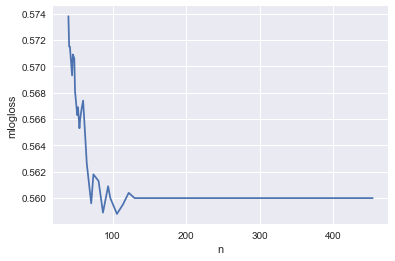

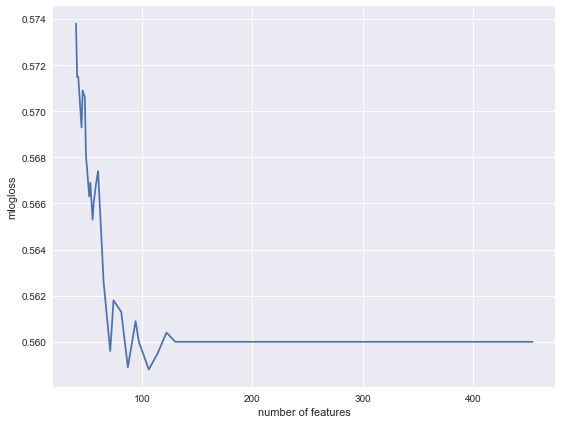

In [3]:
#Visualize Progress over time
import datetime
sot = pd.read_csv("feature_importance_logloss.csv")
#print sot
#dates = list(sot["Date"])
x = sot['n']
y = sot['log_loss']
plt.xlabel('n')
plt.ylabel('mlogloss')
plt.plot(x,y)
plt.figure(figsize=(7,8))

#plt.gcf().autofmt_xdate()

fig32 = plt.figure(figsize=(9,7))

ax = fig32.add_subplot(111)
ax.set_xlabel('number of features')
ax.set_ylabel('mlogloss')
ax.plot(x, y)
fig32.savefig('fig32.png', dpi = 600)
fig32.close()

plt.show()

# Do the plot code

